In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from matplotlib.pyplot import imshow
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, UpSampling2D, Reshape, Permute, Input, concatenate
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Conv3D, Dense, Dropout, MaxPooling3D, Flatten, Add
from keras.utils import np_utils
from keras.utils.np_utils import *
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, CSVLogger
from keras import backend
from PIL import Image
from numba import cuda
import os
import shutil
import tensorflow as tf
import time
train_dir = 'G:\\datalist\\train_dataset_pix\\'
test_dir = 'G:\\datalist\\test_dataset_pix\\'
train_dir_Salinas = 'G:\\datalist\\train_dataset_Salinas_pix\\'
test_dir_Salinas = 'G:\\datalist\\test_dataset_Salinas_pix\\'

Using TensorFlow backend.
D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\py

In [3]:
photo_piece_size = 7

def read_data(data_locate): #读取mat数据
    data=loadmat(data_locate)
    print(data.keys())
    return data

def time_trans(time): #将秒转换成时分秒格式
    hour = int(time/3600)
    minute = int(time%3600 / 60)
    second = time%60
    return str(hour) +' h '+ str(minute) + ' m ' + str(round(second,3)) + ' s'

def make_list(datalen,length): #制作随机坐标列表
    init=0
    data_pix_list= np.empty([np.square(datalen[0]-length),2], dtype = int)
    for con in range(datalen[0]-length):
        for row in range(datalen[1]-length):
            data_pix_list[init]=[con,row]
            init+=1
    return data_pix_list

def predict_photo(data, lable, length, num_list, shrink = [], augment = False): #随机截取出图片并拼接成数据集
    photolable_result = np.ones(num_list.shape[0])
    for i in range(num_list.shape[0]):
        photolable = lable[num_list[i][0]+3][num_list[i][1]+3] #按行截取图像
        photolable_result[i] = photolable
        for b in range(length):
            photo_line = data[num_list[i][0]+b][num_list[i][1]:num_list[i][1]+length] #按行截取图像
            photo_line = np.expand_dims(photo_line,axis=0) #增加维度
            if b==0:
                photo_pick=photo_line
            else:
                photo_pick=np.concatenate((photo_pick,photo_line),axis=0) #将截取的行拼接成图像
            
        photo_pick=np.expand_dims(photo_pick,axis=0) #给图像增加维度
        if i==0:
            photo_result=photo_pick
        else:
            photo_result=np.concatenate((photo_result,photo_pick),axis=0)  #将截取的图像拼接成数据集
    
    photo_result = photo_result.transpose(0, 3, 1, 2)
    
    photo_result = np.expand_dims(photo_result, axis=4)
    
    if len(shrink): #压缩波段数目
        photo_result=photo_result[:, :, :, shrink]
  
    return photo_result,photolable_result

def load_data(filename):
    """read data from data file."""
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return data['data'], data['lable']

class MakeData:
    def __init__(self, filenames, piece_size):
        self.filenames = filenames
        self._indicator = 0
        self.batch_num=0
        self.data, self.lable = load_data(self.filenames[self.batch_num])
        self._num_examples = self.data.shape[0]
        self.piece_size = self.data.shape[1]
        label_all = loadmat('G:\datalist\Indian_pines_gt.mat')
        label_all = np.array(label_all['indian_pines_gt'])
        label_all = np.array(label_all).flatten()
        self.le = LabelEncoder()
        self.le.fit(label_all)
        print(self.le.classes_)
        self.num_classes = len(self.le.classes_)
        label_all = None
        self.list_num = np.array(range(len(self.filenames)))
            
    def next_batch(self, batch_size):
        while True:
            """return batch_size examples as a batch."""
            le = LabelEncoder()
            end_indicator = self._indicator + batch_size
            if end_indicator > self._num_examples:
                if self.batch_num == len(self.filenames):
                    self.batch_num = 0
                    np.random.shuffle(self.list_num)
                self.data, self.lable = load_data(self.filenames[self.list_num[self.batch_num]])
                self.batch_num += 1
                self._indicator = 0
                end_indicator = batch_size

            batch_data = self.data[self._indicator: end_indicator]
            batch_label = self.lable[self._indicator: end_indicator]
            batch_label = np.array(batch_label).flatten()
            batch_label = self.le.transform(batch_label)  
            batch_label = to_categorical(batch_label, num_classes = self.num_classes)
            self._indicator = end_indicator
            yield batch_data, batch_label

class MakeData_salinas:
    def __init__(self, filenames, piece_size):
        self.filenames = filenames
        self._indicator = 0
        self.batch_num=0
        self.data, self.lable = load_data(self.filenames[self.batch_num])
        self._num_examples = self.data.shape[0]
        self.piece_size = self.data.shape[1]
        label_all = loadmat('G:\datalist\Salinas_gt.mat')
        label_all = np.array(label_all['salinas_gt'])
        label_all = np.array(label_all).flatten()
        self.le = LabelEncoder()
        self.le.fit(label_all)
        print(self.le.classes_)
        self.num_classes = len(self.le.classes_)
        label_all = None
        self.list_num = np.array(range(len(self.filenames)))
            
    def next_batch(self, batch_size):
        while True:
            """return batch_size examples as a batch."""
            le = LabelEncoder()
            end_indicator = self._indicator + batch_size
            if end_indicator > self._num_examples:
                if self.batch_num == len(self.filenames):
                    self.batch_num = 0
                    np.random.shuffle(self.list_num)
                self.data, self.lable = load_data(self.filenames[self.list_num[self.batch_num]])
                self.batch_num += 1
                self._indicator = 0
                end_indicator = batch_size

            batch_data = self.data[self._indicator: end_indicator]
            batch_label = self.lable[self._indicator: end_indicator]
            batch_label = np.array(batch_label).flatten()
            batch_label = self.le.transform(batch_label)  
            batch_label = to_categorical(batch_label, num_classes = self.num_classes)
            self._indicator = end_indicator
            yield batch_data, batch_label            
    
def time_trans(time):
    hour = int(time/3600)
    minute = int(time%3600 / 60)
    second = time%60
    return str(hour) +' h '+ str(minute) + ' m ' + str(round(second,3)) + ' s'

train_filenames = [os.path.join(train_dir, '%03d' % i) for i in range(95)]
test_filenames = [os.path.join(test_dir, '%03d' % i) for i in range(95)]

train_data = MakeData(train_filenames, photo_piece_size)
test_data = MakeData(test_filenames, photo_piece_size)

def run_cnn(dilation_rate_list, epoch = 36, cool_down_time = 10, per_epoch = 500):
    
    ###制作模型
    inputs = Input((layers, 7, 7, 1))
    conv1 = Conv3D(16, (7, 3, 3), activation='relu', padding='same', data_format = "channels_last", 
                   kernel_initializer='he_normal')(inputs)
    b1 = BatchNormalization()(conv1)
    conv2 = Conv3D(16, (7, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b1)
    b2 = BatchNormalization()(conv2)
    conv3 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(b2)
    b3 = BatchNormalization()(conv3)
    conv4 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b3)
    b4 = BatchNormalization()(conv4)
    conv5 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(b4)
    b5 = BatchNormalization()(conv5)
    add1 = Add()([b3, b5])
    skip1 = Conv3D(48, (1, 1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(add1)
    skip1_b = BatchNormalization()(skip1)
    conv6 = Conv3D(48, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(add1)
    b6 = BatchNormalization()(conv6)
    conv7 = Conv3D(48, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b6)
    b7 = BatchNormalization()(conv7)
    add2 = Add()([skip1_b, b7])
    skip2 = Conv3D(32, (1, 1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(add2)
    skip2_b = BatchNormalization()(skip2)
    conv8 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(add2)
    b8 = BatchNormalization()(conv8)
    conv9 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b8)
    b9 = BatchNormalization()(conv9)
    conv10 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                    dilation_rate=dilation_rate_list)(b9)
    b10 = BatchNormalization()(conv10)
    add3 = Add()([skip2_b, b10])
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(add3)
    conv11 = Conv3D(24, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(pool1)
    b11 = BatchNormalization()(conv11)
    conv12 = Conv3D(24, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(b11)
    b12 = BatchNormalization()(conv12)
    pool2 = MaxPooling3D(pool_size=(2, 1, 1))(b12)
    conv13 = Conv3D(16, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(pool2)
    b13 = BatchNormalization()(conv13)
    conv14 = Conv3D(16, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(b13)
    b14 = BatchNormalization()(conv14)
    drop1 = Dropout(rate=0.4)(b14)
    flatten1 = Flatten()(drop1)
    full1 = Dense(17, activation='softmax')(flatten1)
    model_dilation_cnn = Model(input = inputs, output = full1)    
    print(model_dilation_cnn.summary())
    
    ###运行模型
    model_dilation_cnn.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1.0e-3), metrics=['accuracy']) #设置参数
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', #设置损失缩减函数
                                  factor = 0.1,
                                  patience = 4,
                                  verbose = 1,
                                  mode = 'auto',
                                  epsilon = 0.0001,
                                  cooldown = 6,
                                  min_lr = 1.0e-6)
    save_model = ModelCheckpoint(filepath = 'G:\\datalist\\model\\model_dilation_cnn_num' + str(dilation_rate_list) + '_{epoch:02d}_{val_loss:.4f}.h5', 
                                 verbose = 1,
                                 period = 2)

    csv_logger = CSVLogger(filename = 'training_dilation_cnn.log')
    class cool_down_class(keras.callbacks.Callback): #设置cpu冷却函数（休眠）
        def on_epoch_end(self, epoch, logs={}):
            for x in range(cool_down_time, -1, -1):
                print("\r" +  "冷却倒计时" + str(x) + "秒" + "  ",end = "")
                time.sleep(1)
            print('\n', end = "")
    cool_down = cool_down_class()
    train_history = model_dilation_cnn.fit_generator(generator = train_data.next_batch(20),  #运行模型
                                        steps_per_epoch = per_epoch, 
                                        epochs = epoch, 
                                        verbose = 1, 
                                        validation_data = test_data.next_batch(20), 
                                        validation_steps = 50,
                                        callbacks = [reduce_lr, save_model, cool_down, csv_logger],
                                        max_q_size = 1)    
    model_dilation_cnn.save('G:\\datalist\\model\\model_dilation_cnn_num' + str(dilation_rate_list)) #保存模型
    
    ###模型预测
    train_locate='G:\\datalist\\Indian_pines_corrected.mat'
    test_locate='G:\\datalist\\Indian_pines_gt.mat'
    photo_piece_size = 7
    pixel_predict_list = np.ones((145-photo_piece_size)*(145-photo_piece_size))
    photo_predict_pic = np.ones((145-photo_piece_size)*(145-photo_piece_size))
    data_train=read_data(train_locate)
    data_lable=read_data(test_locate)
    num_list = make_list(data_train['indian_pines_corrected'].shape,7)
    start_time = time.perf_counter()
    last_time = start_time
    total_time = 0
    for i in range(145-photo_piece_size):
        traind,labled=predict_photo(data_train['indian_pines_corrected'],
                                   data_lable['indian_pines_gt'],
                                   7,
                                   num_list[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)])
        pred = model_dilation_cnn.predict(traind)
        pred = np.argmax(pred, axis = 1)
        pixel_predict_list[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)] = pred
        photo_predict_pic[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)] = labled
        now_time = time.perf_counter()
        elapsed = (now_time - last_time)
        elapsed_str = time_trans(elapsed)
        total_time = now_time - start_time
        total_time_str = time_trans(total_time)
        last_time =now_time
        print("\r" +  'step:%d, spend time: %s, total time: %s' % ((i+1), elapsed_str, total_time_str) +  "                 ",end = "")
    
    ###计算精度
    matrix = confusion_matrix(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic))
    kappa = cohen_kappa_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic))
    matrix_diag = np.diag(matrix)
    matrix_raw_sum = np.sum(matrix, axis = 0)
    each_acc = np.nan_to_num(matrix_diag/matrix_raw_sum)
    aver_acc = np.mean(each_acc)
    each_acc = np.around(each_acc, decimals=5)
    print(str(dilation_rate_list) + ' kappa+oa+aa:')
    print(str(np.around(kappa, decimals=3)))
    print(str(np.around(accuracy_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic)), decimals=3)))
    print(str(np.around(aver_acc, decimals=3)))
    txt_filename = 'G:\\datalist\\z_kappa_oa_aa.txt'
    with open(txt_filename, 'a') as file_object:
        file_object.write('\n' + str(dilation_rate_list) + ' kappa+oa+aa:' + '\n')
        file_object.write(str(np.around(kappa, decimals=3)) + '\n')
        file_object.write(str(np.around(accuracy_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic)), decimals=3)) + '\n')
        file_object.write(str(np.around(aver_acc, decimals=3)) + '\n')
    keras.backend.clear_session()
    tf.reset_default_graph()

print('done')

def run_cnn_salinas(dilation_rate_list, epoch = 36, cool_down_time = 10, per_epoch = 500):
    
    ###制作模型
    inputs = Input((204, 7, 7, 1))
    conv1 = Conv3D(16, (7, 3, 3), activation='relu', padding='same', data_format = "channels_last", 
                   kernel_initializer='he_normal')(inputs)
    b1 = BatchNormalization()(conv1)
    conv2 = Conv3D(16, (7, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(b1)
    b2 = BatchNormalization()(conv2)
    conv3 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(b2)
    b3 = BatchNormalization()(conv3)
    conv4 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b3)
    b4 = BatchNormalization()(conv4)
    conv5 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(b4)
    b5 = BatchNormalization()(conv5)
    add1 = Add()([b3, b5])
    skip1 = Conv3D(48, (1, 1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(add1)
    skip1_b = BatchNormalization()(skip1)
    conv6 = Conv3D(48, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(add1)
    b6 = BatchNormalization()(conv6)
    conv7 = Conv3D(48, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b6)
    b7 = BatchNormalization()(conv7)
    add2 = Add()([skip1_b, b7])
    skip2 = Conv3D(32, (1, 1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(add2)
    skip2_b = BatchNormalization()(skip2)
    conv8 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(add2)
    b8 = BatchNormalization()(conv8)
    conv9 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b8)
    b9 = BatchNormalization()(conv9)
    conv10 = Conv3D(32, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                    dilation_rate=dilation_rate_list)(b9)
    b10 = BatchNormalization()(conv10)
    add3 = Add()([skip2_b, b10])
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(add3)
    conv11 = Conv3D(24, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(pool1)
    b11 = BatchNormalization()(conv11)
    conv12 = Conv3D(24, (3, 5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(b11)
    b12 = BatchNormalization()(conv12)
    pool2 = MaxPooling3D(pool_size=(2, 1, 1))(b12)
    conv13 = Conv3D(16, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal', 
                   dilation_rate=dilation_rate_list)(pool2)
    b13 = BatchNormalization()(conv13)
    conv14 = Conv3D(16, (3, 3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(b13)
    b14 = BatchNormalization()(conv14)
    drop1 = Dropout(rate=0.4)(b14)
    flatten1 = Flatten()(drop1)
    full1 = Dense(17, activation='softmax')(flatten1)
    model_dilation_cnn = Model(input = inputs, output = full1)    
    print(model_dilation_cnn.summary())
    
    ###运行模型
    model_dilation_cnn.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1.0e-3), metrics=['accuracy']) #设置参数
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', #设置损失缩减函数
                                  factor = 0.1,
                                  patience = 4,
                                  verbose = 1,
                                  mode = 'auto',
                                  epsilon = 0.0001,
                                  cooldown = 6,
                                  min_lr = 1.0e-6)
    save_model = ModelCheckpoint(filepath = 'G:\\datalist\\model_Salinas\\model_dilation_cnn_num' + str(dilation_rate_list) + '_{epoch:02d}_{val_loss:.4f}.h5', 
                                 verbose = 1,
                                 period = 2)

    csv_logger = CSVLogger(filename = 'training_dilation_cnn.log')
    class cool_down_class(keras.callbacks.Callback): #设置cpu冷却函数（休眠）
        def on_epoch_end(self, epoch, logs={}):
            for x in range(cool_down_time, -1, -1):
                print("\r" +  "冷却倒计时" + str(x) + "秒" + "  ",end = "")
                time.sleep(1)
            print('\n', end = "")
    cool_down = cool_down_class()
    train_history = model_dilation_cnn.fit_generator(generator = train_data.next_batch(20),  #运行模型
                                        steps_per_epoch = per_epoch, 
                                        epochs = epoch, 
                                        verbose = 1, 
                                        validation_data = test_data.next_batch(20), 
                                        validation_steps = 50,
                                        callbacks = [reduce_lr, save_model, cool_down, csv_logger],
                                        max_q_size = 1)    
    model_dilation_cnn.save('G:\\datalist\\model_Salinas\\model_dilation_cnn_num' + str(dilation_rate_list)) #保存模型
    
    ###模型预测
    train_locate='G:\\datalist\\Salinas_corrected.mat'
    test_locate='G:\\datalist\\Salinas_gt.mat'
    photo_piece_size = 7
    pixel_predict_list = np.ones((512-photo_piece_size)*(217-photo_piece_size))
    photo_predict_pic = np.ones((512-photo_piece_size)*(217-photo_piece_size))
    data_train=read_data(train_locate)
    data_lable=read_data(test_locate)
    num_list = make_list(data_train['salinas_corrected'].shape,7)
    start_time = time.perf_counter()
    last_time = start_time
    total_time = 0
    for i in range(512-photo_piece_size):
        traind,labled=predict_photo(data_train['salinas_corrected'],
                                   data_lable['salinas_gt'],
                                   7,
                                   num_list[i*(217-photo_piece_size):(i+1)*(217-photo_piece_size)])
        pred = model_dilation_cnn.predict(traind)
        pred = np.argmax(pred, axis = 1)
        pixel_predict_list[i*(217-photo_piece_size):(i+1)*(217-photo_piece_size)] = pred
        photo_predict_pic[i*(217-photo_piece_size):(i+1)*(217-photo_piece_size)] = labled

        now_time = time.perf_counter()
        elapsed = (now_time - last_time)
        elapsed_str = time_trans(elapsed)
        total_time = now_time - start_time
        total_time_str = time_trans(total_time)
        last_time =now_time
        print("\r" +  'step:%d, spend time: %s, total time: %s' % ((i+1), elapsed_str, total_time_str) +  "                 ",end = "")

    
    ###计算精度
    matrix = confusion_matrix(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic))
    kappa = cohen_kappa_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic))
    matrix_diag = np.diag(matrix)
    matrix_raw_sum = np.sum(matrix, axis = 0)
    each_acc = np.nan_to_num(matrix_diag/matrix_raw_sum)
    aver_acc = np.mean(each_acc)
    each_acc = np.around(each_acc, decimals=5)
    print(str(dilation_rate_list) + ' kappa+oa+aa:')
    print(str(np.around(kappa, decimals=3)))
    print(str(np.around(accuracy_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic)), decimals=3)))
    print(str(np.around(aver_acc, decimals=3)))
    txt_filename = 'G:\\datalist\\z_kappa_oa_aa_salinas.txt'
    with open(txt_filename, 'a') as file_object:
        file_object.write('\n' + str(dilation_rate_list) + '\n') 
        for aa in range(each_acc.shape[0]):
            file_object.write(str(each_acc[aa]*100) + '\n')
        file_object.write('kappa+oa+aa:' + '\n')
        file_object.write(str(np.around(kappa, decimals=5)) + '\n')
        file_object.write(str(np.around(accuracy_score(np.ravel(pixel_predict_list), np.ravel(photo_predict_pic)), decimals=3)) + '\n')
        file_object.write(str(np.around(aver_acc, decimals=5)) + '\n')
    keras.backend.clear_session()
    tf.reset_default_graph()

print('done')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
done
done


In [ ]:
run_cnn((2,2,2),40,5)

W0121 14:18:13.925748  3824 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0121 14:18:13.946691  3824 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0121 14:18:13.950680  3824 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0121 14:18:14.060386  3824 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0121 14:18

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 7, 7, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 200, 7, 7, 16 1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 7, 7, 16 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 200, 7, 7, 16 16144       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

W0121 14:18:15.897495  3824 deprecation.py:323] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
500/500 [==============================] - 180s 360ms/step - loss: 1.4551 - acc: 0.5994 - val_loss: 1.2771 - val_acc: 0.5360
冷却倒计时0秒  
Epoch 2/40
500/500 [==============================] - 171s 341ms/step - loss: 1.0891 - acc: 0.6489 - val_loss: 1.9737 - val_acc: 0.4560

Epoch 00002: saving model to G:\datalist\model\model_dilation_cnn_num(2, 2, 2)_02_1.9737.h5
冷却倒计时0秒  
Epoch 3/40
500/500 [==============================] - 170s 340ms/step - loss: 0.9808 - acc: 0.6692 - val_loss: 1.1836 - val_acc: 0.5940
冷却倒计时0秒  
Epoch 4/40
500/500 [==============================] - 170s 340ms/step - loss: 0.8670 - acc: 0.7012 - val_loss: 1.2550 - val_acc: 0.5490

Epoch 00004: saving model to G:\datalist\model\model_dilation_cnn_num(2, 2, 2)_04_1.2550.h5
冷却倒计时0秒  
Epoch 5/40
500/500 [==============================] - 170s 340ms/step - loss: 0.7946 - acc: 0.7153 - val_loss: 2.5527 - val_acc: 0.4650
冷却倒计时0秒  
Epoch 6/40
500/500 [==============================] - 170s 339ms/step - loss: 0.6957

In [4]:
run_cnn((5,2,2),40,5)

D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=500, epochs=40, verbose=1, validation_data=<generator..., validation_steps=50, callbacks=[<keras.ca..., max_queue_size=1)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 7, 7, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 200, 7, 7, 16 1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 7, 7, 16 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 200, 7, 7, 16 16144       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Epoch 1/40
500/500 [==============================] - 176s 351ms/step - loss: 1.4654 - acc: 0.6038 - val_loss: 1.8050 - val_acc: 0.4780
冷却倒计时0秒  
Epoch 2/40
500/500 [==============================] - 170s 339ms/step - loss: 1.1196 - acc: 0.6340 - val_loss: 3.5455 - val_acc: 0.3600

Epoch 00002: saving model to G:\datalist\model\model_dilation_cnn_num(5, 2, 2)_02_3.5455.h5
冷却倒计时0秒  
Epoch 3/40
500/500 [==============================] - 170s 339ms/step - loss: 0.9809 - acc: 0.6650 - val_loss: 1.9003 - val_acc: 0.4530
冷却倒计时0秒  
Epoch 4/40
500/500 [==============================] - 169s 339ms/step - loss: 0.9018 - acc: 0.6838 - val_loss: 1.3632 - val_acc: 0.5640

Epoch 00004: saving model to G:\datalist\model\model_dilation_cnn_num(5, 2, 2)_04_1.3632.h5
冷却倒计时0秒  
Epoch 5/40
500/500 [==============================] - 169s 339ms/step - loss: 0.7949 - acc: 0.7164 - val_loss: 3.5917 - val_acc: 0.3610
冷却倒计时0秒  
Epoch 6/40
500/500 [==============================] - 169s 338ms/step - loss: 0.7140

step:138, spend time: 0 h 0 m 0.793 s, total time: 0 h 1 m 51.834 s                 (5, 2, 2) kappa+oa+aa:
0.934
0.952
0.928


In [3]:
run_cnn((6,2,2),40,5)

W0121 08:03:07.774223  9488 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0121 08:03:08.073408  9488 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0121 08:03:08.139232  9488 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0121 08:03:08.374603  9488 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0121 08:03

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 7, 7, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 200, 7, 7, 16 1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 7, 7, 16 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 200, 7, 7, 16 16144       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

W0121 08:03:10.247627  9488 deprecation.py:323] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
500/500 [==============================] - 192s 384ms/step - loss: 1.4462 - acc: 0.5970 - val_loss: 1.4383 - val_acc: 0.5410
冷却倒计时0秒  
Epoch 2/40
500/500 [==============================] - 171s 343ms/step - loss: 1.0803 - acc: 0.6494 - val_loss: 2.0674 - val_acc: 0.4640

Epoch 00002: saving model to G:\datalist\model\model_dilation_cnn_num(6, 2, 2)_02_2.0674.h5
冷却倒计时0秒  
Epoch 3/40
500/500 [==============================] - 172s 343ms/step - loss: 0.9722 - acc: 0.6696 - val_loss: 1.3449 - val_acc: 0.5240
冷却倒计时0秒  
Epoch 4/40
500/500 [==============================] - 171s 341ms/step - loss: 0.8840 - acc: 0.6903 - val_loss: 1.1536 - val_acc: 0.5730

Epoch 00004: saving model to G:\datalist\model\model_dilation_cnn_num(6, 2, 2)_04_1.1536.h5
冷却倒计时0秒  
Epoch 5/40
500/500 [==============================] - 171s 342ms/step - loss: 0.7995 - acc: 0.7131 - val_loss: 1.3871 - val_acc: 0.5430
冷却倒计时0秒  
Epoch 6/40
500/500 [==============================] - 171s 342ms/step - loss: 0.7096

step:138, spend time: 0 h 0 m 0.812 s, total time: 0 h 1 m 52.621 s                 (6, 2, 2) kappa+oa+aa:
0.929
0.948
0.924


In [4]:
run_cnn((7,2,2),40,5)

D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=500, epochs=40, verbose=1, validation_data=<generator..., validation_steps=50, callbacks=[<keras.ca..., max_queue_size=1)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 7, 7, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 200, 7, 7, 16 1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 7, 7, 16 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 200, 7, 7, 16 16144       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Epoch 1/40
500/500 [==============================] - 177s 354ms/step - loss: 1.4043 - acc: 0.6085 - val_loss: 2.0293 - val_acc: 0.4710
冷却倒计时0秒  
Epoch 2/40
500/500 [==============================] - 171s 342ms/step - loss: 1.0809 - acc: 0.6465 - val_loss: 1.7088 - val_acc: 0.5340

Epoch 00002: saving model to G:\datalist\model\model_dilation_cnn_num(7, 2, 2)_02_1.7088.h5
冷却倒计时0秒  
Epoch 3/40
500/500 [==============================] - 171s 342ms/step - loss: 0.9281 - acc: 0.6839 - val_loss: 2.5175 - val_acc: 0.4060
冷却倒计时0秒  
Epoch 4/40
500/500 [==============================] - 171s 342ms/step - loss: 0.8604 - acc: 0.6963 - val_loss: 1.0647 - val_acc: 0.6050

Epoch 00004: saving model to G:\datalist\model\model_dilation_cnn_num(7, 2, 2)_04_1.0647.h5
冷却倒计时0秒  
Epoch 5/40
500/500 [==============================] - 171s 342ms/step - loss: 0.7575 - acc: 0.7259 - val_loss: 1.0325 - val_acc: 0.6240
冷却倒计时0秒  
Epoch 6/40
500/500 [==============================] - 171s 341ms/step - loss: 0.6912

step:138, spend time: 0 h 0 m 0.786 s, total time: 0 h 1 m 52.696 s                 (7, 2, 2) kappa+oa+aa:
0.934
0.951
0.925


In [5]:
run_cnn((2,6,6),40,5)

D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
D:\Users\yanmingjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=500, epochs=40, verbose=1, validation_data=<generator..., validation_steps=50, callbacks=[<keras.ca..., max_queue_size=1)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 7, 7, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 200, 7, 7, 16 1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 7, 7, 16 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 200, 7, 7, 16 16144       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Epoch 1/40
500/500 [==============================] - 371s 742ms/step - loss: 1.4359 - acc: 0.5982 - val_loss: 1.5487 - val_acc: 0.5560
冷却倒计时0秒  
Epoch 2/40
500/500 [==============================] - 364s 728ms/step - loss: 1.0575 - acc: 0.6490 - val_loss: 2.9940 - val_acc: 0.4620

Epoch 00002: saving model to G:\datalist\model\model_dilation_cnn_num(2, 6, 6)_02_2.9940.h5
冷却倒计时0秒  
Epoch 3/40
500/500 [==============================] - 364s 729ms/step - loss: 0.9429 - acc: 0.6721 - val_loss: 1.2320 - val_acc: 0.5660
冷却倒计时0秒  
Epoch 4/40
500/500 [==============================] - 364s 729ms/step - loss: 0.8219 - acc: 0.7077 - val_loss: 0.8909 - val_acc: 0.6610

Epoch 00004: saving model to G:\datalist\model\model_dilation_cnn_num(2, 6, 6)_04_0.8909.h5
冷却倒计时0秒  
Epoch 5/40
500/500 [==============================] - 365s 730ms/step - loss: 0.7606 - acc: 0.7256 - val_loss: 2.2054 - val_acc: 0.3570
冷却倒计时0秒  
Epoch 6/40
500/500 [==============================] - 365s 730ms/step - loss: 0.6596

KeyboardInterrupt: 

In [ ]:
run_cnn((2,7,7),40,5)

In [7]:
from PIL import Image
def run_cnn_model(dilation_rate_list):    
    model_dilation_cnn = load_model('G:\\datalist\\model\\model_dilation_cnn_num' + str(dilation_rate_list))
    train_locate='G:\\datalist\\Indian_pines_corrected.mat'
    test_locate='G:\\datalist\\Indian_pines_gt.mat'
    photo_piece_size = 7
    pixel_predict_list = np.ones((145-photo_piece_size)*(145-photo_piece_size))
    photo_predict_pic = np.ones((145-photo_piece_size)*(145-photo_piece_size))
    data_train=read_data(train_locate)
    data_lable=read_data(test_locate)
    num_list = make_list(data_train['indian_pines_corrected'].shape,7)
    start_time = time.perf_counter()
    last_time = start_time
    total_time = 0
    for i in range(145-photo_piece_size):
        traind,labled=predict_photo(data_train['indian_pines_corrected'],
                                   data_lable['indian_pines_gt'],
                                   7,
                                   num_list[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)])
        pred = model_dilation_cnn.predict(traind)
        pred = np.argmax(pred, axis = 1)
        pixel_predict_list[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)] = pred
        photo_predict_pic[i*(145-photo_piece_size):(i+1)*(145-photo_piece_size)] = labled
        now_time = time.perf_counter()
        elapsed = (now_time - last_time)
        elapsed_str = time_trans(elapsed)
        total_time = now_time - start_time
        total_time_str = time_trans(total_time)
        last_time =now_time
        print("\r" +  'step:%d, spend time: %s, total time: %s' % ((i+1), elapsed_str, total_time_str) +  "                 ",end = "")
    
    from PIL import Image
    pic_filepath = 'G:\\datalist\\result_picture\\Indian pines_dilation_cnn_' + str(dilation_rate_list) + '.png'

    color = np.array([[41 ,36 ,33], [255 ,255 ,0], [0 ,0 ,255], [244 ,164 ,0], [127 ,255 ,212], 
                      [218 ,112 ,214], [160 ,32 ,240], [30 ,144 ,255], [0 ,255 ,127], [255 ,97 ,0], 
                      [106 ,90 ,205], [56 ,94 ,15], [64 ,224 ,208], [189 ,252 ,201], [255 ,192 ,203], 
                      [255 ,235 ,205], [255 ,215 ,0]])

    pixel_predict_list = pixel_predict_list.reshape((145-photo_piece_size),(145-photo_piece_size))
    pixel_output_pic = np.ones((pixel_predict_list.shape[0], pixel_predict_list.shape[1], 3))
    for i in range(pixel_predict_list.shape[0]):
        for j in range(pixel_predict_list.shape[1]):
            for k in range(3):
                #print(pixel_predict_list[i, j])
                color_num = int(pixel_predict_list[i, j])
                pixel_output_pic[i, j, k] = color[color_num, k]

    new_im = Image.fromarray(np.uint8(pixel_output_pic))
    new_im.save(pic_filepath)

    img = Image.open(pic_filepath)
    arrr = np.array(img)
    imshow(arrr)
    keras.backend.clear_session()
    tf.reset_default_graph()

In [5]:
run_cnn_model((2,2,2))

W0131 11:38:40.901819  8532 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0131 11:38:40.924757  8532 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0131 11:38:41.016510  8532 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0131 11:38:41.017508  8532 deprecation_wrapper.py:119] From D:\Users\yanmingjing\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0131 11:3

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
step:138, spend time: 0 h 0 m 0.825 s, total time: 0 h 1 m 56.916 s                 (2, 2, 2) kappa+oa+aa:
0.95325
0.96566
0.94218


dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
step:138, spend time: 0 h 0 m 0.614 s, total time: 0 h 1 m 25.83 s                  

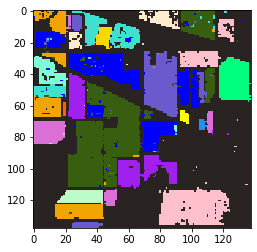

In [8]:
run_cnn_model((1,1,1))

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
step:138, spend time: 0 h 0 m 0.845 s, total time: 0 h 1 m 55.968 s                 

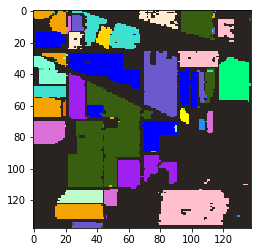

In [9]:
run_cnn_model((6,2,2))